In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import tifffile
import glob

# Functions
Adapted from "Multiplane HiLo microscopy with speckle illumination and non-local means denoising" by Shuqi Zheng, Minoru Koyama and Jerome Mertz.

In [46]:
def set_opts(sigma):
    opts = {}

    # Optical parameters
    opts['NA_det'] = 0.75  # Detection numerical aperture
    opts['NA_ill'] = 0.75  # Illumination numerical aperture
    opts['illumination_wavelength'] = 488e-9  # [m]
    opts['detection_wavelength'] = 530e-9     # [m]
    opts['magnification'] = 33  # With multi-z relay

    # Camera parameters
    opts['camera_gain'] = 1         # [ADU/e-]
    opts['camera_noise'] = 1.4      # [e-]
    opts['pixel_size'] = 6.5e-6     # [m]
    opts['binning'] = 1

    # NLM parameters
    opts['applywavelet'] = 1
    opts['sigma'] = sigma              # HiLo sectioning parameter
    opts['block_size'] = 3            # Block window size (odd) ~ speckle size
    opts['search_size'] = 15          # Search window width = 2*search_size+1
    opts['denoise_flag1'] = 1         # Denoise uniform image
    opts['despeckle_flag2'] = 1       # Despeckle std image
    opts['h1'] = 0.4                  # NLM parameter for denoising u
    opts['h2'] = 10                   # NLM parameter for despeckle std(u-s)

    return opts

In [9]:
def estimate_eta(hi, lo):
    lo = np.copy(lo)
    lo[np.isnan(lo)] = 1e-6 # avoid NaN

    n = hi.size # total number of pixels
    indices = np.random.permutation(n)[:int(0.5 * n)] # gives a random 50% subset of pixels to estimate 'eta', which speeds up computation and avoids bias from any particular region

    hi_flat = hi.flatten() # converts the 2D arrays into 1D vectors
    lo_flat = lo.flatten()

    hi_k = hi_flat[indices] # sampled subset of high‑pass pixel values
    hi_min = hi.min()

    # Filtrer indices selon conditions MATLAB
    # We only want pixels where the high‑pass signal is strongly negative (i.e. high local contrast)
    mask = ~((hi_k > 0.2 * hi_min) | (hi_k >= 0)) # Condition 'hi_k > 0.2 * hi_min' removes values that aren’t at least 20% as deep as the darkest (most negative) values in hi
    # Condition 'hi_k >= 0' removes any non‑negative values (which correspond to flat or low‑contrast regions).
    # ~(...) flips that logic to keep only those indices where hi_k is sufficiently negative
    indices = indices[mask]

    lo_k = lo_flat[indices]
    indices = indices[lo_k >= 1e-9] # drop any indices where the low‑pass pixel is effectively zero (or negative) to avoid multiplying by 0

    numerator = -np.sum(hi_flat[indices]) # assumes 'hi + eta * lo = 0' so 'sum(hi) + eta * sum(lo) = 0' then 'eta = -sum(hi) / sum(lo)'
    denominator = np.sum(lo_flat[indices])
    eta = numerator / denominator if denominator != 0 else 0

    return eta

In [4]:
def freq_coord_norm(imsize):
    """
    Compute normalized frequency coordinates F2, Fu, Fv for image size imsize=(H,W).
    """
    H, W = imsize
    fu = np.linspace(-0.5, 0.5 - 1/H, H)
    fv = np.linspace(-0.5, 0.5 - 1/W, W)
    Fu, Fv = np.meshgrid(fv, fu)
    F2 = Fu**2 + Fv**2
    return F2, Fu, Fv

In [47]:
def pre_process_img_multi(Iu, Is_list, opts):
    """
    Perform HiLo routine on a list of 2D speckled images.

    Inputs:
        Iu (np.ndarray): uniform image (offset subtracted), shape (H, W)
        Is_list (list of np.ndarray): list of 2D speckle images (offset subtracted), each shape (H, W)
        opts (dict): reconstruction parameters including:
            sigma, magnification, NA_ill, NA_det,
            pixel_size, binning, camera_gain, camera_noise,
            illumination_wavelength, detection_wavelength

    Outputs:
        Iest_combined (np.ndarray): estimated image from best contrast
        opts (dict): updated with sigmaHiLo and eta
        C_combined (np.ndarray): maximum contrast map across speckles
    """

    def ft2(x): return np.fft.fft2(x)
    def ift2(x): return np.fft.ifft2(x)

    if Iu.ndim == 2:
        Iu = Iu[:, :, np.newaxis]

    padnum = 5
    Iu_p = np.pad(Iu, ((padnum, padnum), (padnum, padnum), (0, 0)), mode='constant') # pads image to reduce boundary effects

    H, W, _ = Iu_p.shape
    sigma_hilo = opts['sigma'] # gaussian filter size
    F2, Fu, Fv = freq_coord_norm((H, W)) # coord grid for filtering
    p = opts['pixel_size'] * opts['binning'] / opts['magnification']
    K = np.sqrt(F2) / p # spatial frequency magnitude

    OTF_cam = np.sinc(Fu) * np.sinc(Fv)
    OTF_cam[OTF_cam < 0] = 0 # cutoff negative values

    def otf_band(bw): 
        '''compute the system OTF for a given bandwidth using the diffraction-limited disk model'''
        arg = K / bw
        mask = arg <= 1
        otf = np.zeros_like(K)
        otf[mask] = (2 / np.pi) * (np.arccos(arg[mask]) - arg[mask] * np.sqrt(1 - arg[mask]**2))
        return otf

    # calculates bandwidths then builds OTFs
    bw_ill = 2 * opts['NA_ill'] / opts['illumination_wavelength'] 
    bw_det = 2 * opts['NA_det'] / opts['detection_wavelength']
    OTF_det = otf_band(bw_det) * OTF_cam
    OTF_ill = otf_band(bw_ill)

    wavelet_gaussian1 = np.exp(- (np.pi**2) * F2 * opts['sigma']**2)
    wavelet_gaussian2 = np.exp(- (np.pi**2) * F2 * 2 * opts['sigma']**2)
    wavelet_filter = wavelet_gaussian1 - wavelet_gaussian2 # bandpass wavelet filter by subtracting two Gaussians of different widths

    Iest_list = []
    C_list = []

    for Is in Is_list:
        Is = Is[:, :, np.newaxis]
        Is_p = np.pad(Is, ((padnum, padnum), (padnum, padnum), (0, 0)), mode='constant') 

        Iu_local = gaussian_filter(Iu_p, sigma=sigma_hilo)
        Is_local = gaussian_filter(Is_p, sigma=sigma_hilo)
        Iu_filt = Iu_p / Iu_local # local normalization
        Is_filt = Is_p / Is_local
        Id = Iu_filt - Is_filt # computes difference image (supposed to emphasize high freqs)
        Id[(Iu_filt == 0) | (Is_filt == 0)] = 1e-6 # prevents division by 0

        # Estimates the noise variance after wavelet filtering based on camera model and local image intensity
        wavelet_volume = np.sum(np.abs(wavelet_filter)**2) / (H * W)
        noisevar_u = opts['camera_gain'] * Iu_p + (opts['camera_noise'] * opts['camera_gain'])**2
        noisevar_s = opts['camera_gain'] * Is_p + (opts['camera_noise'] * opts['camera_gain'])**2
        noisevar_u /= Iu_local**2
        noisevar_s /= Is_local**2
        noisevar = (noisevar_u + noisevar_s) * wavelet_volume * (1 - 1/sigma_hilo)

        ft_Id = ft2(Id[:, :, 0])
        filt = np.real(ift2(wavelet_filter * ft_Id)) # wavelet Fourier filtering
        C = np.zeros_like(filt)
        diff = filt**2 - noisevar[:, :, 0]

        pos_mask = diff >= 0
        neg_mask = ~pos_mask

        C[pos_mask] = np.sqrt(diff[pos_mask])
        C[neg_mask] = -np.sqrt(-diff[neg_mask])  # equivalent to: sqrt(noisevar - filt**2)

        # C = np.where(filt**2 - noisevar[:, :, 0] >= 0,
        #              np.sqrt(filt**2 - noisevar[:, :, 0]),
        #              -np.sqrt(noisevar[:, :, 0] - filt**2)) # computes the contrast map C (possibly negative if SNR is low, for stability)
        Iest = C * Iu_p[:, :, 0] # estimates the filtered image by weighting the uniform image with the contrast map

        Iest_list.append(Iest)
        C_list.append(C)
        # plt.figure()
        # plt.imshow(C)
        # plt.show()

    Iest_stack = np.stack(Iest_list, axis=-1)
    C_stack = np.stack(C_list, axis=-1)
    best_idx = np.argmax(C_stack, axis=-1) # index of max contrast per pixel

    # Uses best_idx to extract the best Iest and C for each pixel (per-pixel max contrast selection)
    Iest_combined = np.take_along_axis(Iest_stack, best_idx[:, :, np.newaxis], axis=2).squeeze()
    C_combined = np.take_along_axis(C_stack, best_idx[:, :, np.newaxis], axis=2).squeeze() 

    Iest_combined = Iest_combined[padnum:-padnum, padnum:-padnum] # removes the padding added earlier
    C_combined = C_combined[padnum:-padnum, padnum:-padnum]

    # Updates the parameters for further analysis
    opts['eta'] = np.sqrt(np.sum(OTF_ill) / np.sum((wavelet_filter * OTF_det)**2 * OTF_ill))
    opts['sigmaHiLo'] = sigma_hilo

    return Iest_combined, opts, C_combined


# Main

In [48]:
def basic_hilo(uniform_image, speckle_images, sigma=1.5, eta=None, opts=None):
    # 1) Load uniform image
    u = uniform_image.astype(np.float32)
    u[u <= 0] = 1e-6  # avoid zeros
    
    # 2) Load all speckle images into a list
    s_list = []
    for s in speckle_images:
        s = s.astype(np.float32)
        s[s <= 0] = 1e-6
        s_list.append(s)
    
    # 3) Prepare options
    if opts is None:
        opts = set_opts(sigma)
    
    # 4) Multi-speckle HiLo preprocessing
    img_est0, opts, C_combined = pre_process_img_multi(u, s_list, opts)
    
    # 5) Basic HiLo fusion on the uniform image
    sigma = opts['sigmaHiLo']
    hi0 = u - gaussian_filter(u, sigma=sigma)
    lo0 = gaussian_filter(img_est0, sigma=sigma)
    lo0[lo0 < 0] = 1e-6

    hi0_norm = hi0 / np.max(np.abs(hi0))
    lo0_norm = lo0 / np.max(np.abs(lo0))
    
    if eta==None:
        eta = estimate_eta(hi0_norm, lo0_norm)
    # hilo0 = hi0 + eta * lo0
    hilo0 = np.max(np.abs(hi0)) * (hi0_norm + eta * lo0_norm)
    hilo0[hilo0 < 0] = 0

    print("eta = ", eta)
    print("max hi = ", np.max(hi0))
    print("max lo = ", np.max(lo0))
    print("max Iest = ", np.max(img_est0))
    
    # 6) Display original vs. basic HiLo
    plt.figure(figsize=(20, 5))
    
    # plt.subplot(1, 4, 1)
    # plt.imshow(u[..., 0] if u.ndim == 3 else u, cmap='gray', aspect='equal')
    # plt.title('Original Image')
    # plt.axis('off')

    plt.subplot(1, 4, 1)
    plt.imshow(img_est0[..., 0] if img_est0.ndim == 3 else img_est0, cmap='gray', aspect='equal')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(hi0[..., 0] if hi0.ndim == 3 else hi0, cmap='gray', aspect='equal')
    plt.title('hi0')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(lo0[..., 0] if lo0.ndim == 3 else lo0, cmap='gray', aspect='equal')
    plt.title('lo0')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(hilo0[..., 0] if hilo0.ndim == 3 else hilo0, cmap='gray', aspect='equal')
    plt.title('Basic HiLo')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return hilo0, img_est0, C_combined, opts

eta =  153971.82004205108
max hi =  4317.798
max lo =  nan
max Iest =  nan


C:\Users\chloe\AppData\Local\Temp\ipykernel_21588\4068453492.py:64: RuntimeWarning: invalid value encountered in divide
  Iu_filt = Iu_p / Iu_local # local normalization
C:\Users\chloe\AppData\Local\Temp\ipykernel_21588\4068453492.py:65: RuntimeWarning: invalid value encountered in divide
  Is_filt = Is_p / Is_local
C:\Users\chloe\AppData\Local\Temp\ipykernel_21588\4068453492.py:73: RuntimeWarning: divide by zero encountered in divide
  noisevar_u /= Iu_local**2
C:\Users\chloe\AppData\Local\Temp\ipykernel_21588\4068453492.py:74: RuntimeWarning: divide by zero encountered in divide
  noisevar_s /= Is_local**2
C:\Users\chloe\AppData\Local\Temp\ipykernel_21588\4068453492.py:75: RuntimeWarning: invalid value encountered in multiply
  noisevar = (noisevar_u + noisevar_s) * wavelet_volume * (1 - 1/sigma_hilo)


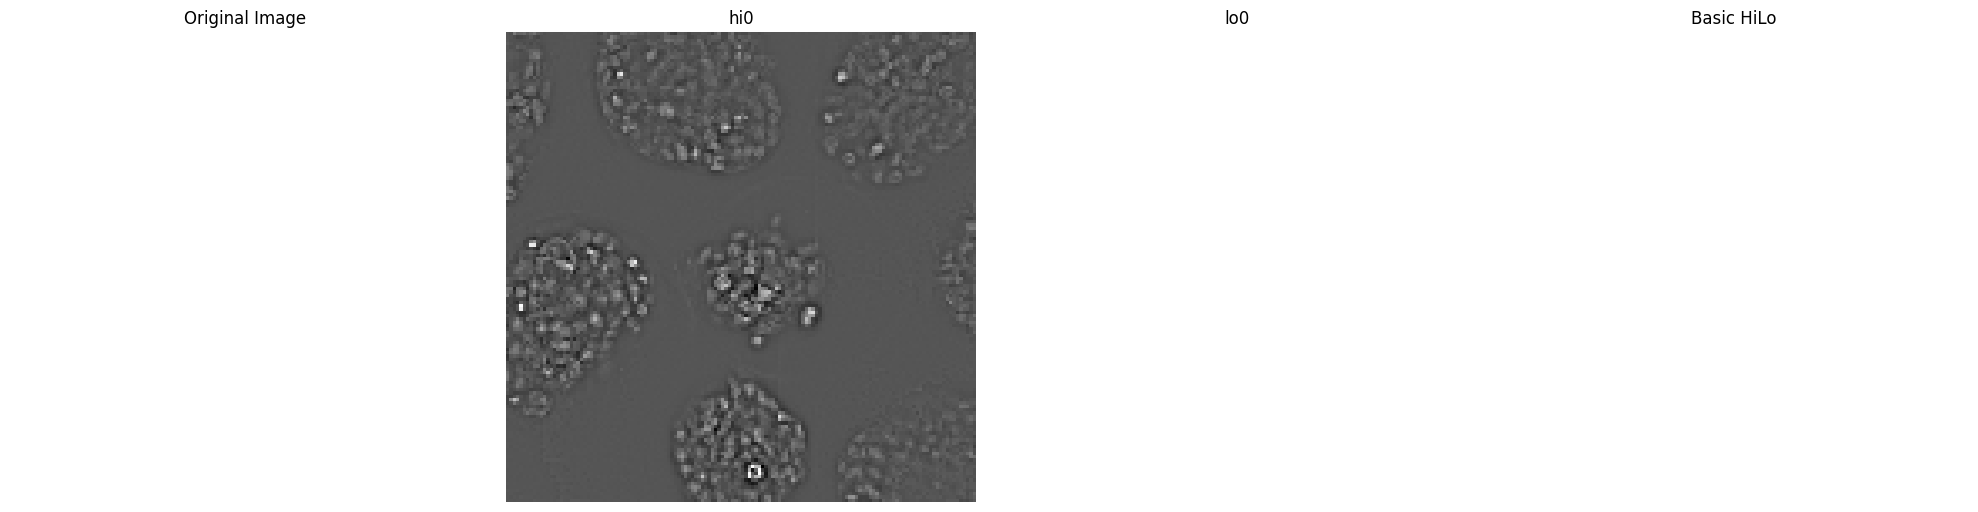

eta =  0.7201106301781105
max hi =  7159.8516
max lo =  72.06060978660938
max Iest =  293.8334305488248


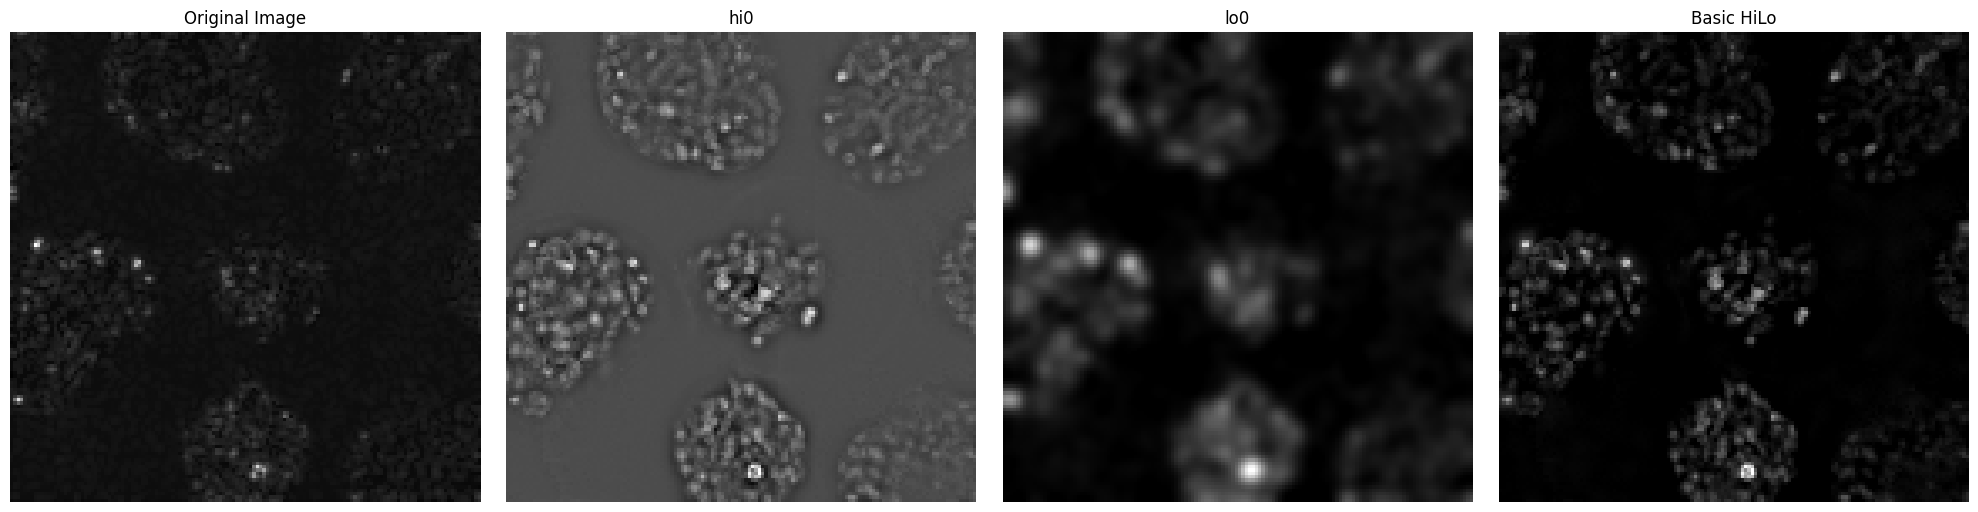

eta =  0.701061598201034
max hi =  8707.779
max lo =  36.566096947042865
max Iest =  143.04952435100353


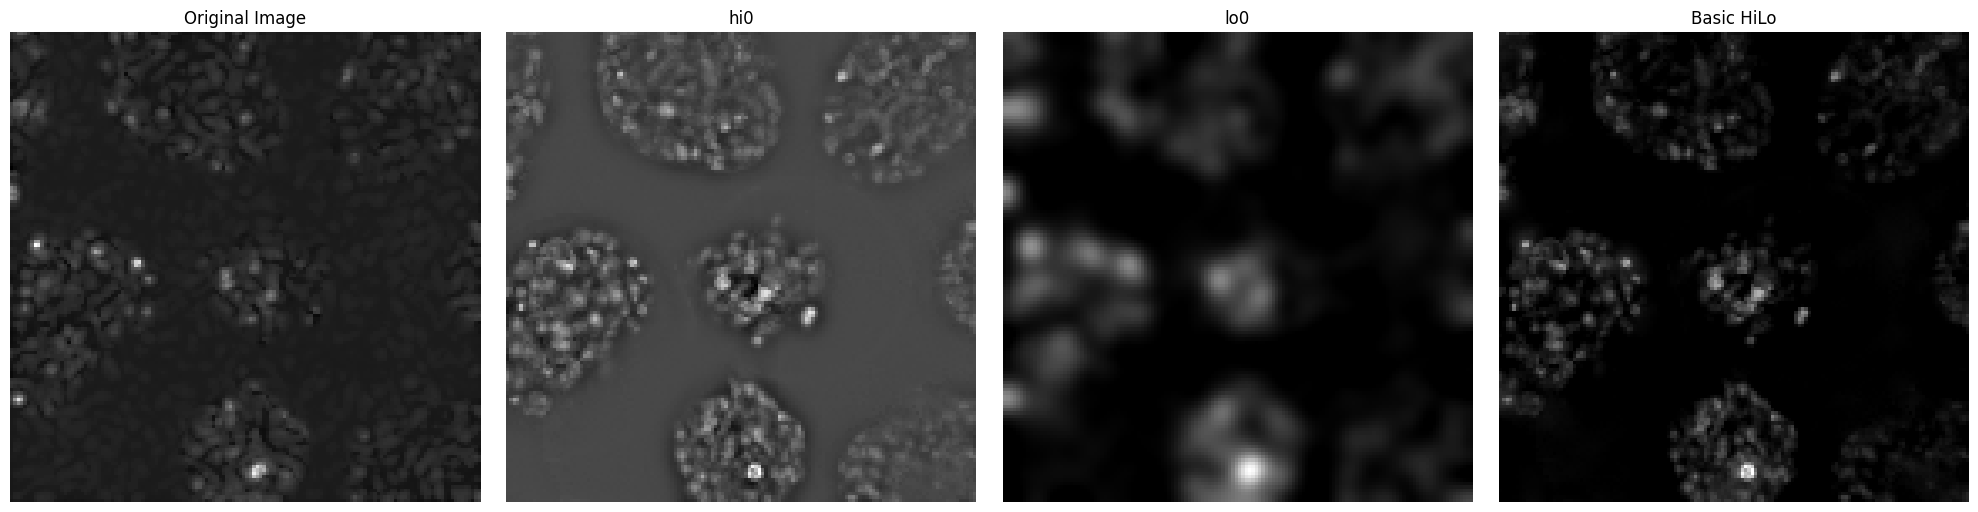

eta =  0.7986585937395619
max hi =  10188.967
max lo =  17.692571519600293
max Iest =  88.71491962478426


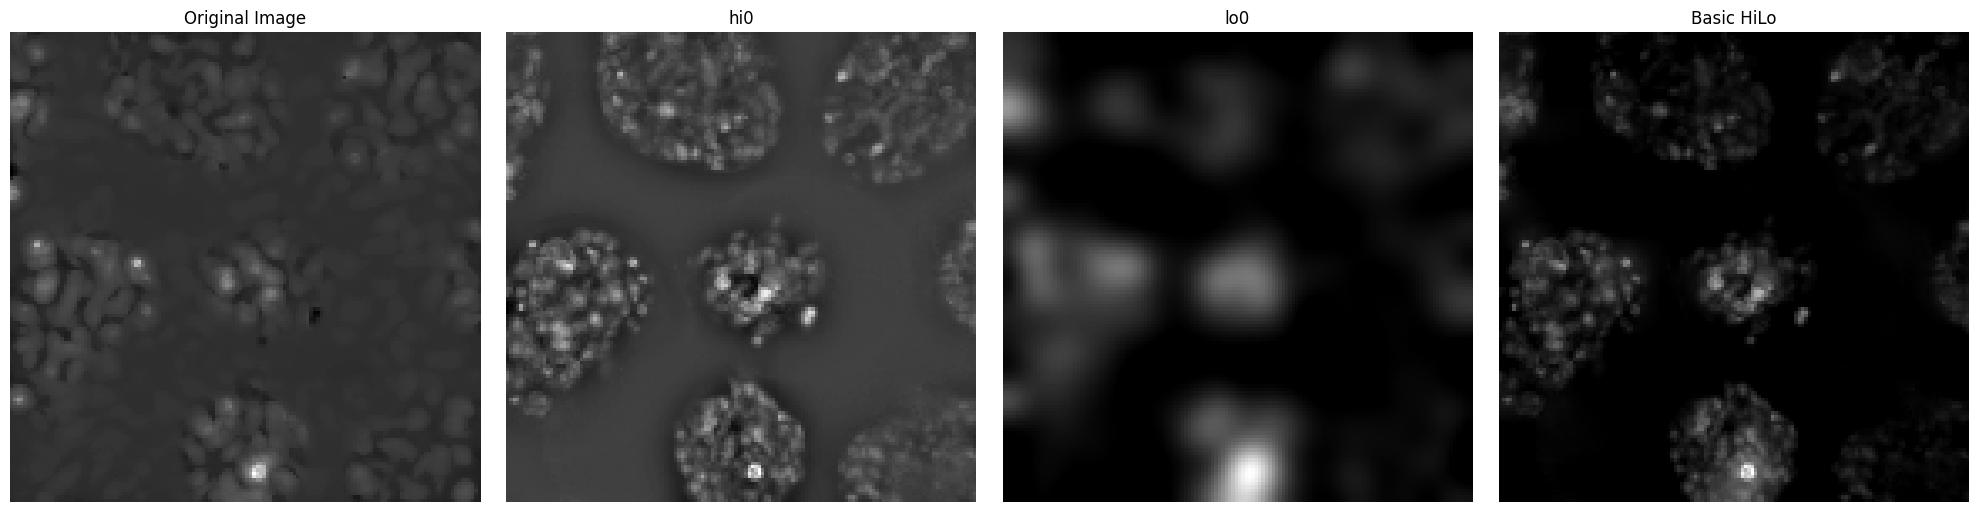

In [50]:
uniform_path="D:/surgele/mai/tests_1305/perspective_centrale.tiff"
patterns_glob="D:/surgele/mai/tests_1305/patterns_hilo/*.tiff"

u = tifffile.imread(uniform_path)
s_list = []
for path in sorted(glob.glob(patterns_glob)):
    s = tifffile.imread(path)
    s_list.append(s)

sigmas=[1, 2, 3, 5]
for sigma in sigmas:
    hilo_img, img_est0, C_map, opts = basic_hilo(u, s_list, sigma=sigma)